In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.nn as nn
import lightning as L
from torchmetrics import MeanSquaredError
from torchinfo import summary
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

import optuna
import torch.optim as optim

from sklearn import tree, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import parse_version

SEQ_LENGTH = 4

/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA

In [2]:
df = pd.read_csv("01_data_processing.ipynb.output/disease_rates_wide.csv")
#remove any columsn that contain yr
columns_to_drop = [col for col in df.columns if "yr" in col]
df = df.drop(columns=columns_to_drop)

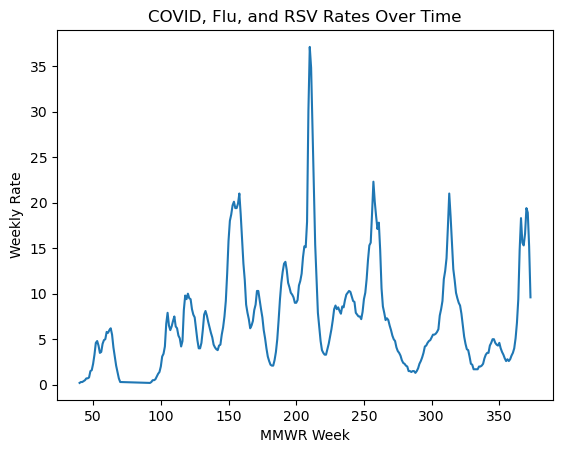

In [3]:
plt.plot(df['mmwr_week'], df['All'])
plt.title('COVID, Flu, and RSV Rates Over Time')
plt.xlabel('MMWR Week')
plt.ylabel('Weekly Rate')
plt.show()

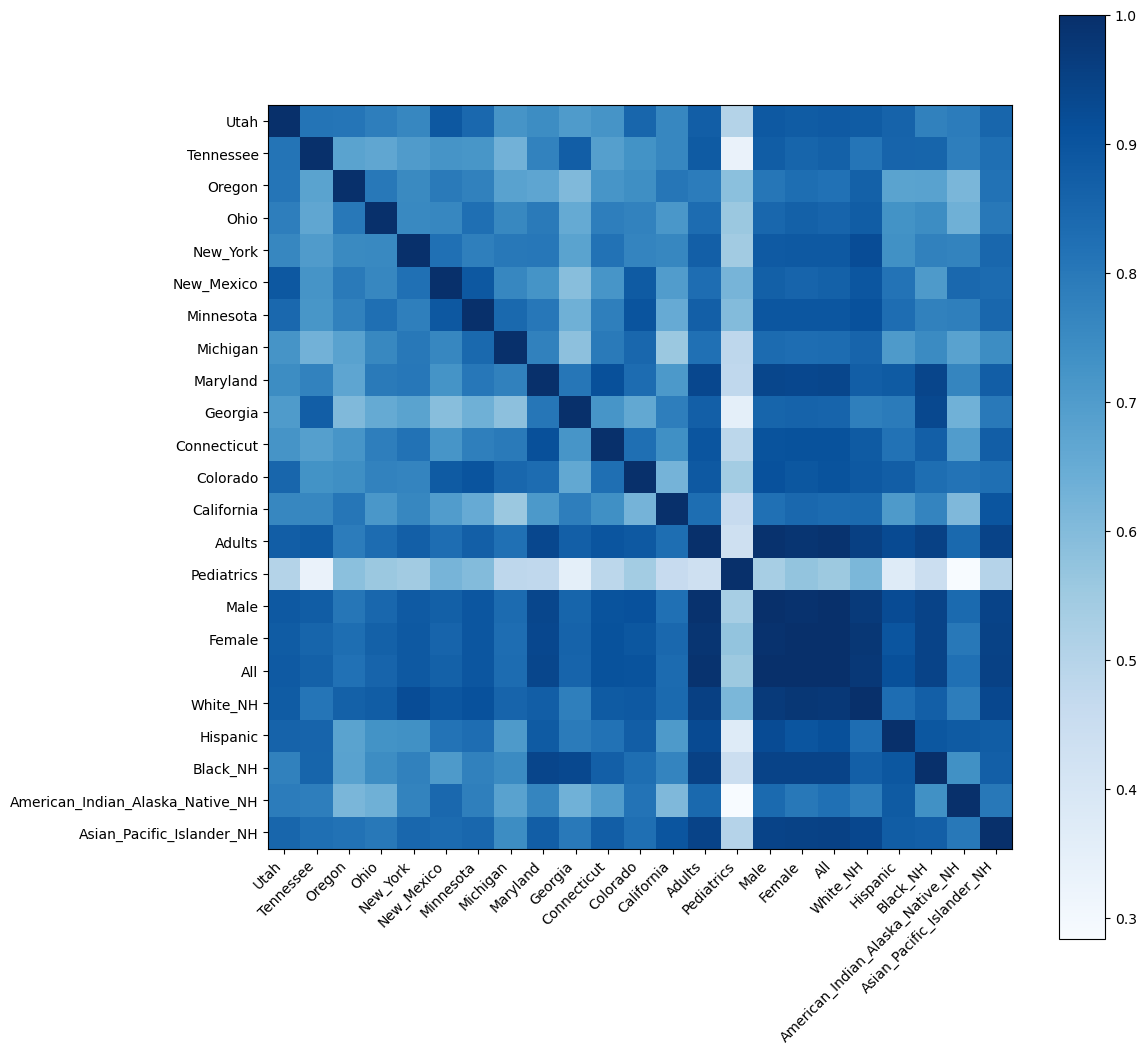

In [4]:
matrix = df.drop('mmwr_week', axis=1).corr()
fig = plt.figure(figsize=(12, 12))
# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

# Preparing Data

In [5]:
#make a train, val, and test set
train = df[(df["mmwr_week"] >= 0) & (df["mmwr_week"] < 200)]#end of 2018, 2019, 2020, 2021
val = df[(df["mmwr_week"] >= 200) & (df["mmwr_week"] < 280)]#2022, 2023
test = df[(df["mmwr_week"] >= 280)]#2024, the start of 2025
train = train.drop('mmwr_week', axis=1)
val = val.drop('mmwr_week', axis=1)
test = test.drop('mmwr_week', axis=1)

## For Sklearn implemntation of gradient boosting regressor
#split data into X and y
X_train = train
X_val = val
X_test = test
y_train = train[['All']].values
y_val = val[['All']].values
y_test = test[['All']].values

#matching up rows so that data in X corresponds to the All value for the next week for y
#remove last row from X dfs
X_train = X_train.iloc[:-1]
X_val = X_val.iloc[:-1]
X_test = X_test.iloc[:-1]
#remove the first row from y 
y_train = y_train[1:].reshape(-1)
y_val = y_val[1:].reshape(-1)
y_test = y_test[1:].reshape(-1)

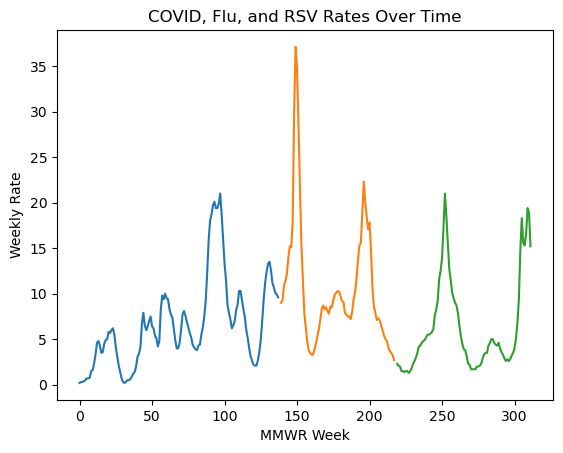

In [6]:
plt.plot(X_train['All'])
plt.plot(X_val['All'])
plt.plot(X_test['All'])


plt.title('COVID, Flu, and RSV Rates Over Time')
plt.xlabel('MMWR Week')
plt.ylabel('Weekly Rate')
plt.show()

In [7]:
from torch.utils.data import TensorDataset

def timeseries_dataset_from_array(sequence, targets, sequence_length, start_index=0, end_index=None):
    X, y = [], []
    end_index = (len(sequence) - sequence_length) if end_index is None else end_index
    for i in range(start_index, end_index):
        X.append(sequence[i: i + sequence_length])
        y.append(targets[i])

    return torch.from_numpy(np.array(X)).float(), torch.from_numpy(np.array(y)).float()


#create each dataset
ds_train = TensorDataset(*timeseries_dataset_from_array(
    train.values,
    train[['All']].values,
    SEQ_LENGTH))

ds_val = TensorDataset(*timeseries_dataset_from_array(
    val.values,
    val[['All']].values,
    SEQ_LENGTH))

ds_test = TensorDataset(*timeseries_dataset_from_array(
    test.values,
    test[['All']].values,
    SEQ_LENGTH))

len(ds_train), len(ds_val), len(ds_test)

(135, 76, 90)

In [8]:
from torch.utils.data import DataLoader

dl_train = DataLoader(ds_train, batch_size=5, num_workers=2, shuffle=True,
                      persistent_workers=True, drop_last=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=5, num_workers=2, shuffle=False,
                    persistent_workers=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=5, num_workers=2, shuffle=False,
                     persistent_workers=True, pin_memory=True)

# Gradient Boosting Regressor

### Hyperparameter Tuning

In [9]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators": 1000,
    "max_depth": 20,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

param_dist = {
    'learning_rate': np.arange(0.001, 0.2, 0.01), 
    'n_estimators': [100, 200, 300, 400, 500],  
    'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    "min_samples_split": [3, 5, 7, 9, 11, 13, 15, 17, 19],
}

gb_model = ensemble.GradientBoostingRegressor()

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test)
print("Best Parameters:", best_params)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 19, 'max_depth': 15, 'learning_rate': 0.13099999999999998}


### Training

In [10]:
reg = ensemble.GradientBoostingRegressor(**best_params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 3.8198


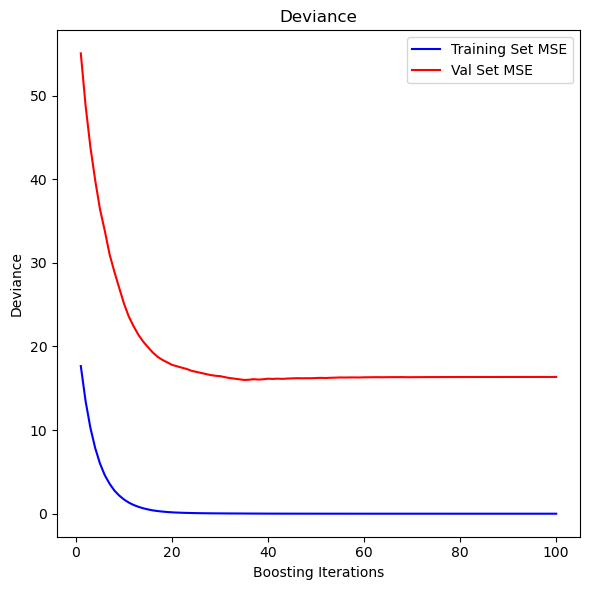

In [11]:
val_score = np.zeros((best_params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_val)):
    val_score[i] = mean_squared_error(y_val, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(best_params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set MSE",
)
plt.plot(
    np.arange(best_params["n_estimators"]) + 1, val_score, "r-", label="Val Set MSE"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

# Long Short Term Memory Forecaster

In [12]:
class BaseForecaster(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr

        self.train_mse = MeanSquaredError()
        self.val_mse = MeanSquaredError()
        self.test_mse = MeanSquaredError()
        
    def forward(self, x):
        pass

    def _common_step(self, batch, batch_idx, metric, loss_lbl, metric_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.mse_loss(logits, y)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(metric_lbl, metric(logits, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_mse, "loss", "mse")

    def on_training_epoch_end(self):
        self.log("mse", self.train_mse.compute())
        self.train_mse.reset()

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_mse, "val_loss", "val_mse")

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_mse.compute())
        self.val_mse.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_mse, "test_loss", "test_mse")

    def on_test_epoch_end(self):
        self.log("test_mse", self.test_mse.compute())
        self.test_mse.reset()

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.lr)

In [13]:
class LSTMForecaster(BaseForecaster):
    def __init__(self,hidden_size1=200,hidden_size2=200,hidden_size3=200, lr=0.001, sequence_length=10):
        super().__init__(lr)
        self.sequence_length = sequence_length
        self.lstm1 = nn.LSTM(input_size=23, hidden_size=hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(hidden_size2*self.sequence_length, hidden_size3),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        x = x.view(-1, self.sequence_length, 23)
        o, _ = self.lstm1(x)
        o, _ = self.lstm2(o)
        o = self.flatten(o)
        o = self.linear(o)
        return self.out(o)


### Hyperparamter Tuning

In [14]:
def objective(trial):
    # Hyperparameters to tune
    hidden_size1 = trial.suggest_int('hidden_size1', 32, 512)
    hidden_size2 = trial.suggest_int('hidden_size2', 32, 512)
    hidden_size3 = trial.suggest_int('hidden_size3', 32, 512)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    

    model = LSTMForecaster(hidden_size1,hidden_size2,hidden_size3,sequence_length=SEQ_LENGTH)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop 
    model.train()
    for epoch in range(5):
        for batch_idx, (data, target) in enumerate(dl_train):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print("Best Hyperparameters:", study.best_params)

[I 2025-04-22 14:12:06,334] A new study created in memory with name: no-name-4676ed96-0467-41bd-91da-0e43d62948e6
[I 2025-04-22 14:12:09,049] Trial 0 finished with value: 0.8496378660202026 and parameters: {'hidden_size1': 49, 'hidden_size2': 330, 'hidden_size3': 417, 'lr': 0.0007600283199166238}. Best is trial 0 with value: 0.8496378660202026.
[I 2025-04-22 14:12:11,156] Trial 1 finished with value: 2.916921377182007 and parameters: {'hidden_size1': 138, 'hidden_size2': 307, 'hidden_size3': 237, 'lr': 0.009840543754854984}. Best is trial 0 with value: 0.8496378660202026.
[I 2025-04-22 14:12:13,735] Trial 2 finished with value: 0.43691110610961914 and parameters: {'hidden_size1': 203, 'hidden_size2': 330, 'hidden_size3': 323, 'lr': 0.0012212002814954424}. Best is trial 2 with value: 0.43691110610961914.
[I 2025-04-22 14:12:22,535] Trial 3 finished with value: 1.6860675811767578 and parameters: {'hidden_size1': 487, 'hidden_size2': 496, 'hidden_size3': 505, 'lr': 6.236187295113071e-05}.

Best Hyperparameters: {'hidden_size1': 162, 'hidden_size2': 40, 'hidden_size3': 411, 'lr': 0.001910606046835762}


### Training

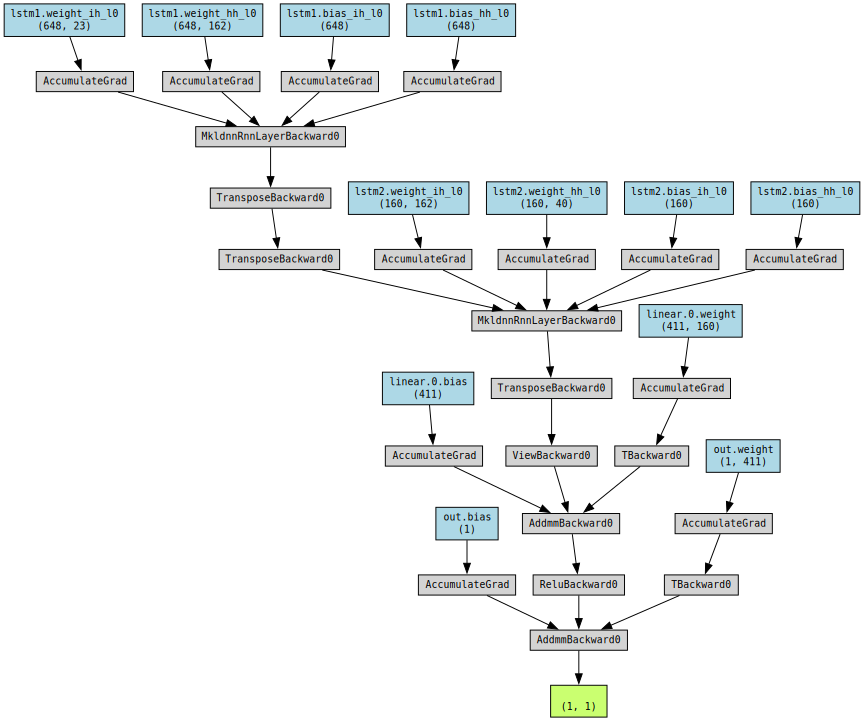

In [16]:
lstm_model = LSTMForecaster(sequence_length=SEQ_LENGTH,hidden_size1=study.best_params['hidden_size1'],hidden_size2=study.best_params['hidden_size2'],hidden_size3=study.best_params['hidden_size3'],lr=study.best_params['lr'])
summary(lstm_model)
from torchviz import make_dot
make_dot(lstm_model(ds_train[0][0].unsqueeze(dim=0)), params=dict(lstm_model.named_parameters()))

In [17]:
logger = CSVLogger("logs", name="lstm")

trainer = L.Trainer(max_epochs=500, callbacks=[
    ModelCheckpoint(
        monitor='val_loss', mode='min', save_last=True, save_top_k=1,
        dirpath='checkpoints/', filename='lstm-{epoch:02d}-{val_loss:.2f}',
    ),
    EarlyStopping(monitor='val_loss', patience=30, mode='min')
], logger=logger,log_every_n_steps=20, enable_progress_bar = False)
trainer.fit(lstm_model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/uufs/chpc.utah.edu/sys/installdir/r8/miniconda3-bmi6114/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /uufs/chpc.utah.edu/common/home/u1159162/deep_learning_class/BMI6114-DL-Final-Project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | train_mse | MeanSquaredError | 0     
1 | val_mse   | MeanSquaredError | 0     
2 | test_mse  | MeanSquaredError | 0     
3 | lstm1     | LSTM             | 121 K 
4 | lstm2     | LSTM             | 32.6 K
5 | flatten   | Flatten          | 0     
6 | linear    | Sequential       | 66.2 K
7 | out       | Linear           | 412   
-----------------------------------------------
220 K     Trainable params
0         Non-trainab

/scratch/local/u1159162/4057335/ipykernel_158048/1201773202.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hist[['mse', 'loss']] = hist[['mse', 'loss']].fillna(method='ffill')
/scratch/local/u1159162/4057335/ipykernel_158048/1201773202.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hist[['val_mse', 'val_loss']] = hist[['val_mse', 'val_loss']].fillna(method='bfill')


<Axes: >

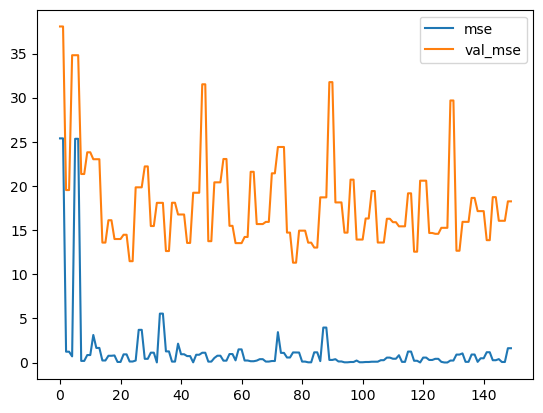

In [18]:
hist = pd.read_csv(f"./logs/lstm/version_{len(os.listdir('./logs/lstm/')) - 1}/metrics.csv")
hist[['mse', 'loss']] = hist[['mse', 'loss']].fillna(method='ffill')
hist[['val_mse', 'val_loss']] = hist[['val_mse', 'val_loss']].fillna(method='bfill')
hist[['mse', 'val_mse']].plot()

# Plotting Results

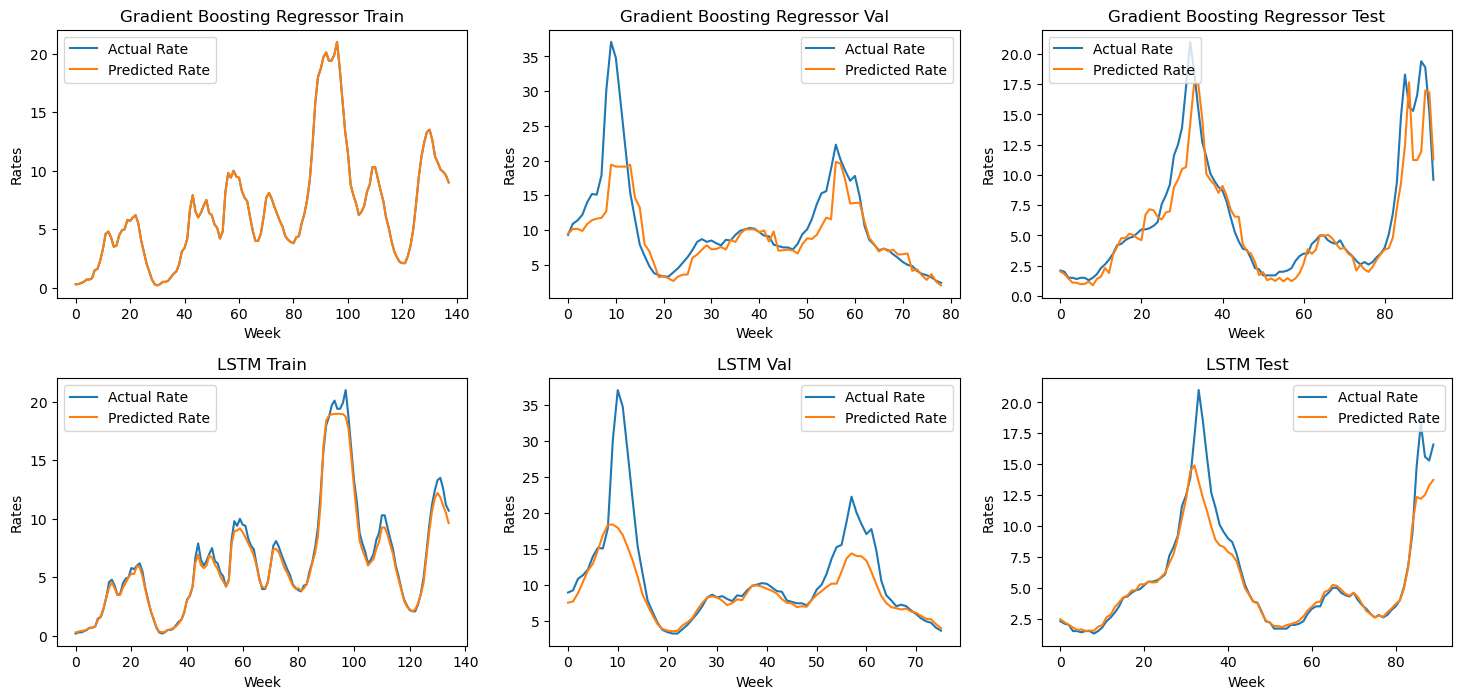

In [19]:
def plot_actual_vs_predicted_pytorch(model, ds, label,sbplot_coord_1,sbplot_coord_2,sbplot_coord_3):
    
    y = ds.tensors[1]
    y_hat = model(ds.tensors[0]).detach()
    
    pd.DataFrame(torch.concat((y, y_hat), axis=1),
        columns=["Actual Rate", "Predicted Rate"]).plot(
        xlabel="Week", ylabel="Rates",ax=plt.subplot(sbplot_coord_1,sbplot_coord_2,sbplot_coord_3))

    plt.title(f"{label}")
    
def plot_actual_vs_predicted_sklearn(model, X, y, label,sbplot_coord_1,sbplot_coord_2,sbplot_coord_3):
    
    y_hat = model.predict(X)
    pd.DataFrame({"Actual Rate":y.reshape(-1),  
        "Predicted Rate":y_hat.reshape(-1)}).plot(
        xlabel="Week", ylabel="Rates",ax=plt.subplot(sbplot_coord_1,sbplot_coord_2,sbplot_coord_3))

    plt.title(f"{label}")

fig = plt.figure(figsize=(18,8))
plot_actual_vs_predicted_sklearn(reg, X_train, y_train, "Gradient Boosting Regressor Train", 2, 3, 1)
plot_actual_vs_predicted_sklearn(reg, X_val, y_val, "Gradient Boosting Regressor Val", 2, 3, 2)
plot_actual_vs_predicted_sklearn(reg, X_test, y_test, "Gradient Boosting Regressor Test", 2, 3, 3)

plot_actual_vs_predicted_pytorch(lstm_model, ds_train, "LSTM Train", 2, 3, 4)
plot_actual_vs_predicted_pytorch(lstm_model, ds_val, "LSTM Val", 2, 3, 5)
plot_actual_vs_predicted_pytorch(lstm_model, ds_test, "LSTM Test", 2, 3, 6)


plt.subplots_adjust(wspace=.2, hspace=.3) 
plt.show()


In [20]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set for GBR: {:.4f}".format(mse))
mse = mean_squared_error(ds_test.tensors[1], lstm_model(ds_test.tensors[0]).detach())
print("The mean squared error (MSE) on test set for LSTM: {:.4f}".format(mse))

The mean squared error (MSE) on test set for GBR: 3.8198
The mean squared error (MSE) on test set for LSTM: 2.3275
